In [7]:
import sys
import ray
import time
import math
import os


In [8]:
ray.init()

2022-07-26 23:32:35,628	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '172.28.6.160',
 'raylet_ip_address': '172.28.6.160',
 'redis_address': '172.28.6.160:6379',
 'object_store_address': '/tmp/ray/session_2022-07-26_23-32-35_146553_37707/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-07-26_23-32-35_146553_37707/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-07-26_23-32-35_146553_37707',
 'metrics_export_port': 60383,
 'node_id': '1586b34fa8edaba7ad876283501ca54c33f9f528'}

In [914]:
prefix = ""
traffic_config_template = {
    "wkld" : "FbHdp_distribution",
    "nhost" : 64,
    "load" : 0.6,
    "time_s" : 0.1,
    "incast" : 0,
    "pattern" : 0
}

cc_config_template = { 
    "cc" : "",
    "slow_unit" : 0,
    "ack_highprio" : 1,
    "abc_dt" : 0,
    "abc_delta" : 12000, 
    "abc_token" : 50,
    "abc_eta" : 0.95,
    "utgt" : 95,
    "abc_dqinterval" : 1000,
    "abc_tokenminbound" : 1,
    "abc_ratebound" : 0,
    "abc_markmode" : 1
}
def configlst_to_namelst(config_lst):
    lst = []
    for config in config_lst:
        if config['cc'].find('abc') != -1:
            cc_name = "{}dt{:.1f}dl{:.1f}token{}eta{}mark{}".format(config['cc'], float(config['abc_dt']), float(config['abc_delta']),
                                                  config['abc_token'], config['abc_eta'], config['abc_markmode'])
            if(int(config['abc_tokenminbound']) ==0):
                cc_name+= "noTkMin"
            if (int(config['abc_dqinterval']) == 0):
                cc_name+= "dq0"
            if (int(config['abc_ratebound'])):
                cc_name+= "rb"
            lst.append(cc_name)
        elif config['cc'] == 'hp':
            lst.append("hp{}ai80".format(config['utgt']))
        else:
             lst.append(config['cc'])
    return lst

cmd_template="""--c {cc} \
    --bw 100 \
    --topo 2layer \
    --hpai 80 \
    --slow_unit {slow_unit} \
    --ack_highprio {ack_highprio} \
    --abc_dt {abc_dt}  \
    --abc_delta {abc_delta} \
    --abc_token {abc_token} \
    --abc_eta {abc_eta} \
    --utgt {utgt} \
    --abc_dqinterval {abc_dqinterval} \
    --abc_tokenminbound {abc_tokenminbound} \
    --abc_ratebound {abc_ratebound} \
    --abc_markmode {abc_markmode}
"""
@ray.remote
def launch(trace, cc_config):    
    work_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation"
    os.chdir(work_dir)
    cmd = cmd_template.format(**cc_config)
    print("python run.py --trace {} {}".format(trace, cmd))
    os.system("python run.py --trace {} {}".format(trace, cmd))

def gen_trafic_config(traffic_config):
    wkld = traffic_config['wkld']
    nhost = traffic_config['nhost']
    load = traffic_config['load']
    time_s = traffic_config['time_s']
    incast = traffic_config['incast']
    pattern = traffic_config['pattern'] 
    work_dir = "/home/cxyzhao/High-Precision-Congestion-Control/traffic_gen"
    os.chdir(work_dir)
    output_name = "{}_n{}_load{}_t{}_incast{}_pattern{}".format(wkld, nhost, load, time_s, incast, pattern)
    
    #Check if requried file already exist
    dataset_files = os.listdir("/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix")
    for file in dataset_files:
         if file.find(output_name + ".txt") !=-1:
                #Already generate required files
                return output_name
            
    cmd = "python traffic_gen.py -c {}.txt -n {} -l {} -b 100G -t {} -o {}.txt -i {} -p {}".format(wkld, nhost, load, time_s, output_name, incast, pattern)
    os.system(cmd)
    mix_path =  work_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix"
    os.system("cp ./{}.txt {}".format(output_name, mix_path))
    return output_name

In [1090]:
import copy
#"1longflow"

w4_l60_config = copy.deepcopy(traffic_config_template)
w4_l60 = gen_trafic_config(w4_l60_config)


w4_l30_incast_config = copy.deepcopy(traffic_config_template)
w4_l30_incast_config['load'] = 0.3
w4_l30_incast_config['incast'] = 1
w4_l30_incast = gen_trafic_config(w4_l30_incast_config)

w4_l30_config = copy.deepcopy(traffic_config_template)
w4_l30_config['load'] = 0.3
w4_l30_config['incast'] = 0
w4_l30 = gen_trafic_config(w4_l30_config)



cc_config_lst = []

# for cc in ["abc"]:
#     for abc_eta in [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]:
#         for abc_token in [50]:
#             for abc_delta in [12000]:
#                 for abc_dqinterval in [1000]:
#                     for abc_tokenminbound in [1]:
#                         for abc_markmode in [1]:
#                             cc_config = copy.deepcopy(cc_config_template)
#                             cc_config['cc']  = cc
#                             cc_config['abc_eta'] = abc_eta
#                             cc_config['abc_token'] = abc_token
#                             cc_config['abc_delta'] = abc_delta
#                             cc_config['abc_dqinterval'] =  abc_dqinterval
#                             cc_config['abc_tokenminbound'] = abc_tokenminbound
#                             cc_config['abc_markmode'] = abc_markmode
#                             cc_config_lst.append(cc_config)

# for cc in ["abc"]:
#     for abc_eta in [0.95]:
#         for abc_token in [50]:
#             for abc_delta in [12000]:
#                 for abc_dqinterval in [1000]:
#                     for abc_tokenminbound in [1]:
#                         for abc_markmode in [1]:
#                             cc_config = copy.deepcopy(cc_config_template)
#                             cc_config['cc']  = cc
#                             cc_config['abc_eta'] = abc_eta
#                             cc_config['abc_token'] = abc_token
#                             cc_config['abc_delta'] = abc_delta
#                             cc_config['abc_dqinterval'] =  abc_dqinterval
#                             cc_config['abc_tokenminbound'] = abc_tokenminbound
#                             cc_config['abc_markmode'] = abc_markmode
#                             cc_config_lst.append(cc_config)

for cc in ["dctcp", "dcqcn", "timely", "hp"]:
    cc_config = copy.deepcopy(cc_config_template)
    cc_config['cc']  = cc
    cc_config_lst.append(cc_config)


lst = []
for cc_config in cc_config_lst:
    f_id = launch.remote(w4_l60, cc_config)
    lst.append(f_id)                        
#             ray.wait(lst, num_returns=len(lst))
#             lst = []

(pid=38377) python run.py --trace FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0 --c hp     --bw 100     --topo 2layer     --hpai 80     --slow_unit 0     --ack_highprio 1     --abc_dt 0      --abc_delta 12000     --abc_token 50     --abc_eta 0.95     --utgt 95     --abc_dqinterval 1000     --abc_tokenminbound 1     --abc_ratebound 0     --abc_markmode 1
(pid=38377) 
(pid=38404) python run.py --trace FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0 --c dctcp     --bw 100     --topo 2layer     --hpai 80     --slow_unit 0     --ack_highprio 1     --abc_dt 0      --abc_delta 12000     --abc_token 50     --abc_eta 0.95     --utgt 95     --abc_dqinterval 1000     --abc_tokenminbound 1     --abc_ratebound 0     --abc_markmode 1
(pid=38404) 
(pid=38326) python run.py --trace FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0 --c dcqcn     --bw 100     --topo 2layer     --hpai 80     --slow_unit 0     --ack_highprio 1     --abc_dt 0      --abc_delta 12000     --abc_token 50     --a

(pid=38377) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38404) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38326) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38396) Waf: Entering directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38377) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38377) 'build' finished successfully (0.360s)
(pid=38404) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38404) 'build' finished successfully (0.359s)
(pid=38326) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38326) 'build' finished successfully (0.357s)
(pid=38396) Waf: Leaving directory `/home/cxyzhao/High-Precision-Congestion-Control/simulation/build'
(pid=38396) 'build' finishe

(pid=38377) ENABLE_QCN			Yes
(pid=38377) USE_DYNAMIC_PFC_THRESHOLD	Yes
(pid=38377) PACKET_PAYLOAD_SIZE		1000
(pid=38377) TOPOLOGY_FILE			mix/2layer.txt
(pid=38377) FLOW_FILE			mix/FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0.txt
(pid=38377) TRACE_FILE			mix/trace.txt
(pid=38377) TRACE_OUTPUT_FILE		mix/mix_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_hp95ai80.tr
(pid=38377) FCT_OUTPUT_FILE		mix/fct_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_hp95ai80.txt
(pid=38377) PFC_OUTPUT_FILE				mix/pfc_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_hp95ai80.txt
(pid=38377) SIMULATOR_STOP_TIME		2.1
(pid=38377) CC_MODE		3
(pid=38377) ALPHA_RESUME_INTERVAL		1
(pid=38377) RATE_DECREASE_INTERVAL		4
(pid=38377) CLAMP_TARGET_RATE		No
(pid=38377) RP_TIMER			300
(pid=38377) EWMA_GAIN			0.00390625
(pid=38377) FAST_RECOVERY_TIMES		1
(pid=38377) RATE_AI				80Mb/s
(pid=38377) RATE_HAI			80Mb/s
(pid=38377) MIN_RATE		1000Mb/s
(pid=38

(pid=38377) maxRtt=8240 maxBdp=103000
(pid=38377) Running Simulation.
(pid=38404) maxRtt=8240 maxBdp=103000
(pid=38404) Running Simulation.
(pid=38326) maxRtt=8240 maxBdp=103000
(pid=38326) Running Simulation.
(pid=38396) maxRtt=8240 maxBdp=103000
(pid=38396) Running Simulation.


In [1086]:
import subprocess
import argparse

def get_pctl(a, p):
    i = int(len(a) * p)
    return a[i]

def get_results_df(cc, prefix, percent = 50):
    work_dir = "/home/cxyzhao/High-Precision-Congestion-Control/analysis/"
    cmd = 'python {}/fct_analysis.py -c {} -p {}'.format(work_dir, cc, prefix)
    x = subprocess.check_output(cmd, shell=True)
    lines = x.decode().split("\n")
    find_fct = False
    fsize_lst = []
    fct_lst = []
    for line in lines:
        if len(line) == 0:
            continue
        if(line.find('FCT') != -1):
            find_fct = True
        elif (find_fct):
            fsize_lst.append(int(line.split(',')[0]))
            percent_to_idx = {50:1, 95:2, 99:3}
            fct_lst.append(float(line.split(',')[percent_to_idx[percent]]))
    
    #generate DataFrame
    lst = {}     
    lst["FlowSize"] = fsize_lst
    fct_name = cc
    lst[fct_name] = fct_lst
    return pd.DataFrame(lst)
    

def concat_df(df_lst):
    df = df_lst[0]
    for i in range(1, len(df_lst)):
        df = pd.concat([df, df_lst[i]])
    return df

def single_str_translate(name): 
        name_map = {'abc': 'ABC',
        'mark1': '',
        'mark2': 'Piecewise',
        'mark3': 'WRED',
        'noTkMin' : 'NoTokenLimit',
               }
        for key in name_map.keys():
            name = name.replace(key, name_map[key])
        return name
    
def variable_name_translate(df):
    name_map = {'abc': 'ABC',
        'mark1': '',
        'mark2': 'Piecewise',
        'mark3': 'Wred',
        'noTkMin' : 'NoTokenLimit',
               }
    for key in name_map.keys():
        df['variable'] = [ single_str_translate(name) for name in df['variable'] ]
    return df

                   
percent = 95
prefix = "fct_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1"

cc_config_lst = []
# for cc in ["abc"]:
#     for abc_eta in [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]:
#         for abc_token in [50]:
#             for abc_delta in [12000]:
#                 for abc_dqinterval in [1000]:
#                     for abc_tokenminbound in [0]:
#                         for abc_markmode in [1]:
#                             cc_config = copy.deepcopy(cc_config_template)
#                             cc_config['cc']  = cc
#                             cc_config['abc_eta'] = abc_eta
#                             cc_config['abc_token'] = abc_token
#                             cc_config['abc_delta'] = abc_delta
#                             cc_config['abc_dqinterval'] =  abc_dqinterval
#                             cc_config['abc_tokenminbound'] = abc_tokenminbound
#                             cc_config['abc_markmode'] = abc_markmode
#                             cc_config_lst.append(cc_config)

for cc in ["abc"]:
    for abc_eta in [0.95]:
        for abc_token in [50]:
            for abc_delta in [12000]:
                for abc_dqinterval in [0, 1000]:
                    for abc_tokenminbound in [1]:
                        for abc_markmode in [1]:
                            cc_config = copy.deepcopy(cc_config_template)
                            cc_config['cc']  = cc
                            cc_config['abc_eta'] = abc_eta
                            cc_config['abc_token'] = abc_token
                            cc_config['abc_delta'] = abc_delta
                            cc_config['abc_dqinterval'] =  abc_dqinterval
                            cc_config['abc_tokenminbound'] = abc_tokenminbound
                            cc_config['abc_markmode'] = abc_markmode
                            cc_config_lst.append(cc_config)

# for cc in ["dctcp", "hp"]:
#     cc_config = copy.deepcopy(cc_config_template)
#     cc_config['cc']  = cc
#     cc_config_lst.append(cc_config)

df_lst = []
for cc in configlst_to_namelst(cc_config_lst):
    df_lst.append(get_results_df(cc=cc, prefix=prefix, percent=percent))

df = concat_df(df_lst)



/home/cxyzhao/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'FCT Slow Down')

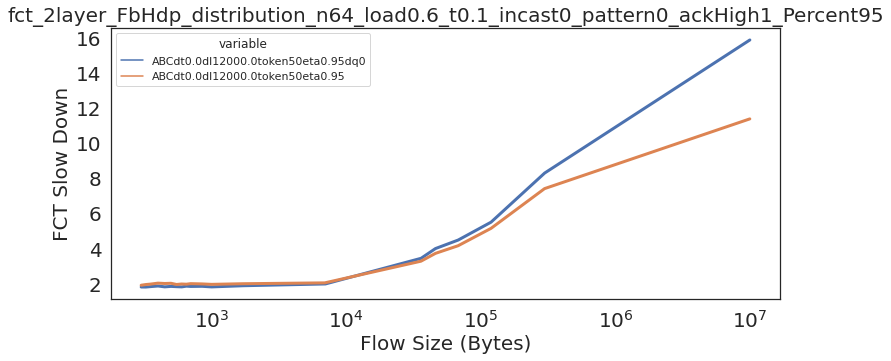

(pid=38404) 4379.69
(pid=38320) 4392.04


In [1087]:
sns.set(rc={'figure.figsize':(12,5)})
sns.set_style('white')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
data_ = variable_name_translate(pd.melt(df, 'FlowSize'))
g= sns.lineplot('FlowSize', 'value', hue='variable', 
             data=data_ , linewidth = 3)
g.set_title("{}_Percent{}".format(prefix, percent), fontsize = 20)
g.set_xscale('log')
g.set_xlabel("Flow Size (Bytes)", fontsize = 20)
g.set_ylabel("FCT Slow Down", fontsize = 20)

Text(0, 0.5, 'Queue Length (KB)')

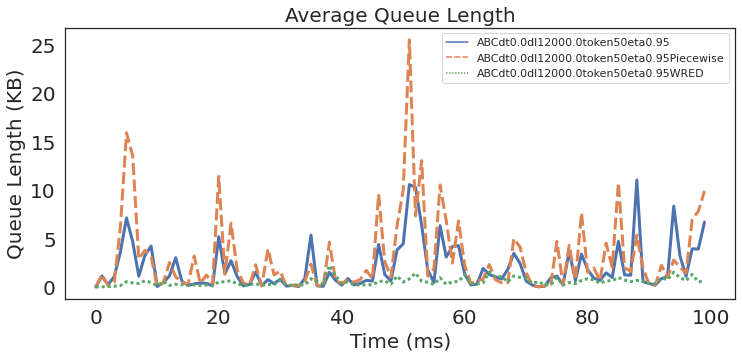

In [997]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def get_avg_qlen(df):
    df = df.fillna(0.0)
    tseries_qlen_avg = []
    for column in df.columns[0:]:
        if column == 0:
            delta_qlen_dist = df[column]
        else:
            delta_qlen_dist = df[column] - df[column-1]
        total_cnt = 0.0
        total_val = 0.0
        for i in range(len(delta_qlen_dist)):
            total_val += delta_qlen_dist[i] * i
            total_cnt += delta_qlen_dist[i]
        tseries_qlen_avg.append(total_val / total_cnt)
    return pd.DataFrame(tseries_qlen_avg, columns=["Avg_qLen"])

qlen_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/"

prefix = "qlen_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_"
qlen_name_lst = []
for cc in configlst_to_namelst(cc_config_lst):
    qlen_name_lst.append(prefix+cc)

df =pd.DataFrame()
for qlen_name in qlen_name_lst:
    qlen_file = qlen_dir + qlen_name + ".txt"
    cc_name  = qlen_name[74:]
    port_to_qlenDist = {}
    with open(qlen_file) as f:
        lines =f.readlines()
        for line in lines:
            if line.find("time") != -1:
                continue
            else:
                lst = line.split()
                lst = [int(i) for i in lst]
                name = "switch{}port{}".format(lst[0], lst[1])
                if name not in port_to_qlenDist.keys():
                    port_to_qlenDist[name] = []
                port_to_qlenDist[name].append(lst[2:])
                
    avg_qlen = get_avg_qlen(pd.DataFrame(port_to_qlenDist["switch64port20"]).T)
    avg_qlen.columns = [cc_name]
    df = pd.concat([df, avg_qlen])

sns.set(rc={'figure.figsize':(12,5)})
sns.set_style('white')

#g.set_yticks([5000 * (i+1) for i in range(8)])

#g.set_yticklabels(g.get_yticks(), size=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

df.columns = [single_str_translate(name) for name in df.columns]

g= sns.lineplot(data=df, linewidth=3)

g.set_title("Average Queue Length", fontsize = 20)
g.set_xlabel("Time (ms)", fontsize = 20)
g.set_ylabel("Queue Length (KB)", fontsize = 20)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.legend([],[], frameon=False)



[(0.0, 200.0)]

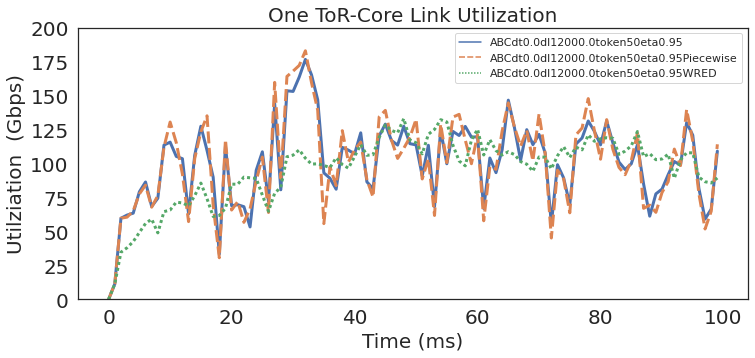

In [998]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def tranfer_name(cc_name):
    cc_name = cc_name.replace("aabc", "pw-abc")
    cc_name = cc_name.replace("rabc", "wr-abc")
    return cc_name

link_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/"



prefix = "link_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_"
link_name_lst = []
for cc in configlst_to_namelst(cc_config_lst):
    link_name_lst.append(prefix+cc)
    
df =pd.DataFrame()
for link_name in link_name_lst:
    link_file = link_dir + link_name + ".txt"
    cc_name  = link_name[74:]
    port_to_linkutil_series = {}
    with open(link_file) as f:
        lines =f.readlines()
        for line in lines:
            if line.find("time") != -1:
                continue
            else:
                lst = line.split()
                lst = [float(i) for i in lst]
                name = "switch{}port{}".format(int(lst[0]), int(lst[1]))
                if name not in port_to_linkutil_series.keys():
                    port_to_linkutil_series[name] = []
                port_to_linkutil_series[name].append(lst[2])


    cc_name  = tranfer_name(cc_name)
    df = pd.concat([df, pd.DataFrame(port_to_linkutil_series["switch64port24"], columns=[cc_name]) ], axis=1)




#accu_avg = df.expanding().mean()
#accu_avg.columns = ["CumulativeAverage-HPCC", "CumulativeAverage-ABC"]
#df = pd.concat([df, accu_avg])
# df = df.expanding().mean()

sns.set(rc={'figure.figsize':(12,5)})
sns.set_style('white')

#g.set_yticks([5000 * (i+1) for i in range(8)])

#g.set_yticklabels(g.get_yticks(), size=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

df.columns = [single_str_translate(name) for name in df.columns]
g= sns.lineplot(data=df, linewidth = 3)

g.set_title("One ToR-Core Link Utilization", fontsize = 20)
g.set_xlabel("Time (ms)", fontsize = 20)
g.set_ylabel("Utilziation  (Gbps)", fontsize = 20)
g.set(ylim=(0, 200))
# g.set(xlim=(0, 30))
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend([],[], frameon=False)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


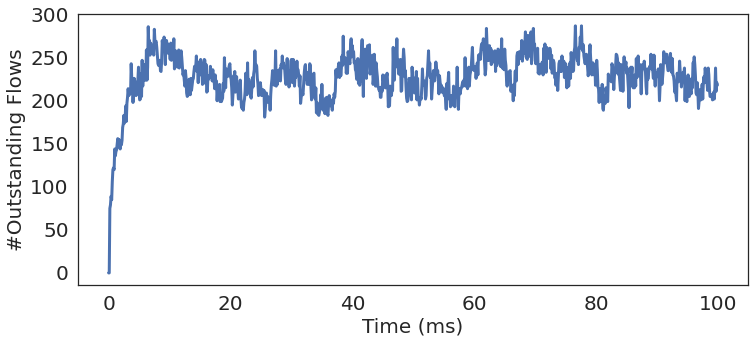

In [973]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def tranfer_name(cc_name):
    cc_name = cc_name.replace("aabc", "pw-abc")
    cc_name = cc_name.replace("rabc", "wr-abc")
    return cc_name

file_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/"

prefix = "outflow_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_"
file_name_lst = []
for cc in configlst_to_namelst(cc_config_lst):
    file_name_lst.append(prefix+cc)
    break
    


df =pd.DataFrame()
for file_name in file_name_lst:
    _file = file_dir + file_name + ".txt"
    cc_name  = _file[74:]
    counters = []
    with open(_file) as f:
        lines =f.readlines()
        #cur_counter  = [0 for i in range(64)]
        cur_counter = 0
        for line in lines:
            if line.find("time") != -1:
                counters.append(cur_counter)
                #cur_counter  = [0 for i in range(64)]
                cur_counter = 0
                continue
            else:
                lst = line.split()
                if(len(lst) < 3):
                    continue
                lst = [int(i) for i in lst]
                cur_counter += lst[2]


    cc_name  = tranfer_name(cc_name)
    cc_name = "ABC"
    df = pd.concat([df, pd.DataFrame(counters, columns=[cc_name]) ], axis=1)



df['Cumulative Moving Average'] = df.expanding().mean()

sns.set(rc={'figure.figsize':(12,5)})
sns.set_style('white')

#g.set_yticks([5000 * (i+1) for i in range(8)])

#g.set_yticklabels(g.get_yticks(), size=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
g= sns.lineplot(data=df, x=df.index * 0.1, y='ABC', linewidth = 3)
#g.set_title("#Outstanding Flows", fontsize = 20)
g.set_xlabel("Time (ms)", fontsize = 20)
g.set_ylabel("#Outstanding Flows", fontsize = 20)
# g.set(ylim=(0, 100))
# g.set(xlim=(0, 30))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend([],[], frameon=False)



Text(0, 0.5, 'CDF')

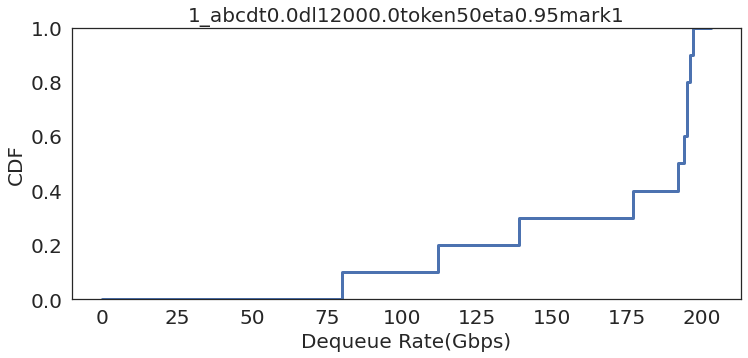

In [1085]:
#For dqrate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

dqrate_dir = "/home/cxyzhao/High-Precision-Congestion-Control/simulation/mix/"

prefix = "dqrate_2layer_FbHdp_distribution_n64_load0.6_t0.1_incast0_pattern0_ackHigh1_"
cc_config_lst = []
for cc in ["abc"]:
    for abc_eta in [0.95]:
        for abc_token in [50]:
            for abc_delta in [12000]:
                for abc_dqinterval in [1000]:
                    for abc_tokenminbound in [1]:
                        for abc_markmode in [1]:
                            cc_config = copy.deepcopy(cc_config_template)
                            cc_config['cc']  = cc
                            cc_config['abc_eta'] = abc_eta
                            cc_config['abc_token'] = abc_token
                            cc_config['abc_delta'] = abc_delta
                            cc_config['abc_dqinterval'] =  abc_dqinterval
                            cc_config['abc_tokenminbound'] = abc_tokenminbound
                            cc_config['abc_markmode'] = abc_markmode
                            cc_config_lst.append(cc_config)
                            
dqrate_name_lst = []
for cc in configlst_to_namelst(cc_config_lst):
    dqrate_name_lst.append(prefix+cc)

df =pd.DataFrame()
for dqrate_name in dqrate_name_lst:
    dqrate_file = dqrate_dir + dqrate_name + ".txt"
    cc_name  = dqrate_name[74:]
    port_to_dqrateDist = {}
    with open(dqrate_file) as f:
        lines =f.readlines()
        for line in lines:
            if line.find("time") != -1:
                continue
            else:
                lst = line.split()
                lst = [int(i) for i in lst]
                name = "switch{}port{}queue{}".format(lst[0], lst[1], lst[2])
                if name not in port_to_dqrateDist.keys():
                    port_to_dqrateDist[name] = []
                port_to_dqrateDist[name].append(lst[3:])
                
    dqrate = pd.DataFrame(port_to_dqrateDist["switch66port20queue3"]).T 
    dqrate = pd.DataFrame(dqrate[30])
    dqrate.columns = [cc_name]
    df = pd.concat([df, dqrate])
    
# #     avg_qlen = get_avg_qlen(pd.DataFrame(port_to_qlenDist["switch64port20queue3"]).T)
# #     avg_qlen.columns = [cc_name]
# #     df = pd.concat([df, avg_qlen])

sns.set(rc={'figure.figsize':(12,5)})
sns.set_style('white')

#g.set_yticks([5000 * (i+1) for i in range(8)])

#g.set_yticklabels(g.get_yticks(), size=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)


#g = sns.ecdfplot(data=df, linewidth=3, x=df.index)
g = sns.ecdfplot(data=df, linewidth=3, x=df.index, weights=cc_name)
#g = sns.lineplot(data=df, linewidth=3)

g.set_title(cc_name, fontsize = 20)
g.set_xlabel("Dequeue Rate(Gbps)", fontsize = 20)
g.set_ylabel("CDF", fontsize = 20)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.legend([],[], frameon=False)

